# Prepare input and run test case for TopoFlow Glacier Component: 
# Wolverine Glacier, AK
The USGS has monitored the Wolverine Glacier, drained by [Wolverine Creek (USGS-15236900)](https://waterdata.usgs.gov/monitoring-location/15236900/#parameterCode=00065&period=P7D&showMedian=false), for several years as part of the [USGS Benchmark Glacier Project](https://www.usgs.gov/programs/climate-research-and-development-program/science/glaciers-and-climate-project). They provide observed meteorological data for the Wolverine Glacier, which we processed and use in this notebook to demonstrate how to use the glacier energy balance component of TopoFlow. This component models both snowmelt and glacier ice melt, and is thus intended to **replace** the TopoFlow snow component when ice is present in your study domain. The glacier component does **not** model glacier accumulation, only melt.  

### Set your working directory

In [ ]:
# Change these directories as necessary
import os, os.path

# This is your home directory and it is used throughout this notebook.
home_dir = os.path.expanduser("~")

### Download source data for the region of interest

#### Option 1 (Quickstart): 
If you want to skip the process of actually _creating_ input data, and use inputs that are ready out-of-the-box, simply: 

1. Download the `WolverineGlacier` data in the [examples](https://github.com/NOAA-OWP/topoflow/tree/master/topoflow/examples) folder to a folder on your machine located at `{home_dir}/basins/WolverineGlacier`

2. Ensure that a folder exists for storing the model output at `{home_dir}/ouput/WolverineAK`

**Now, you can skip to the "Run TopoFlow" block of this notebook, and do the subsequent data visualization.**


#### Option 2 (Full Process):
**Complete the rest of the steps in this notebook _prior_ to running the "Run TopoFlow" block.**

[<b>MERIT DEM</b>](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/) tiles can be downloaded for specific areas of interest. For this case, download the GeoTIFF for **n60w150**. You'll need to sign up for a free username and password to access the DEM. You should receive credentials within minutes of registering. 

In this test case, the goal is to output combined snow and glacier ice melt, so certain steps related to gathering important data (e.g. soils, catchment characteristics, etc.) for accurate streamflow estimates, infiltration, and channel routing will be skipped. For a more complete tutorial on preparing data to run all TopoFlow components, see the [<b>Sagehen Test Case example</b>](https://github.com/peckhams/topoflow36/blob/master/notebooks/TopoFlow_Prepare_Input_Data_Sagehen2.ipynb). 

In [1]:
# It is preferred to use a MERIT DEM with floating-point elevations.
# Go to this URL:  http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/
# to download the tile listed here (5x5 degrees). 
# Change the corresponding file path as needed. 
src_dem_dir  = home_dir + '/DEMs/MERIT_Tiles/GeoTIFF/'
src_dem      = 'n60w150_dem.tif'

tf_data_dir      = home_dir + '/TF_Data/'
cfg_template_dir = tf_data_dir + '_Test1/cfg_templates/'
# src_outlet_dir   = tf_data_dir + '_Test1/outlet_files/' # TODO: is this even necessary? If not, delete

print( 'Home directory =', home_dir )
print( 'Source DEM directory   =', src_dem_dir )
print( 'CFG template directory =', cfg_template_dir )

Home directory = /Users/laurenbolotin
Source DEM directory   = /Users/laurenbolotin/DEMs/MERIT_Tiles/GeoTIFF/
CFG template directory = /Users/laurenbolotin/TF_Data/_Test1/cfg_templates/


### Set the site_prefix, case_prefix and Common Info  <a id="choose_B"></a> 
Here, we set some site-specific information, mostly pertaining to channel routing, which is not the focus of this example, so only the *site_prefix* needs to be properly set for the basin of interest. The channels component of TopoFlow, however, must be enabled to run the model, so we still provide best-guess values. 

In [2]:
site_prefix = 'WolverineGlacier'
case_prefix  = 'Test1'

#--------------------------------------------------------
# The following info does not need to be perfect since it 
# is intended for streamflow outputs, which are not 
# analyzed here.
#--------------------------------------------------------
channel_width_power = 0.5
max_sinuosity   = 1.2    # [m/m] 
min_manning_n   = 0.03   # [m / s^(1/3)]
max_manning_n   = 0.2    # [m / s^(1/3)]
bankfull_depth_power = 0.4
bank_angle = 30.0   # [degrees]
DRAINS_TO_OCEAN = False   # (this is the default)

### Create the necessary directories for model input/output

In [3]:
import glob
import shutil

test_dir  = home_dir + '/basins/'
basin_dir = test_dir + site_prefix + '/'
topo_dir  = basin_dir + '__topo/'
met_dir   = basin_dir + '__met/'

if not(os.path.exists( test_dir )):  
    os.mkdir( test_dir )
if not(os.path.exists( basin_dir )): 
    os.mkdir( basin_dir )
if not(os.path.exists( topo_dir )):  
    os.mkdir( topo_dir )
if not(os.path.exists( met_dir )):   
    os.mkdir( met_dir )

print( 'Home directory  =', home_dir )
print( 'Basin directory =', basin_dir )

Home directory  = /Users/laurenbolotin
Basin directory = /Users/laurenbolotin/basins/WolverineGlacier/


### Set model run information

In [4]:
start_date_str  = '2016-10-01' 
end_date_str    = '2017-09-30'
date_range_str  = '2016-10_to_2017-09'
extension       = '_' + date_range_str + '.rts'
GMT_offset_str  = '-9'  # Alaska Time
start_month_str = 'October'
start_day_str   = '1'
T_stop_str      = '525600'  # [minutes] # 1 non leap year

rain_type_str  = 'w990' # data comes from Wolverine met. station 990
met_dt_str     = '3600.0'  # [secs]  60 * 60 (secs in 1 hr)

In [5]:
case_info_str = date_range_str + '_' + rain_type_str
cfg_dir = basin_dir + 'Test1_' + case_info_str + '_cfg/'
if not(os.path.exists( cfg_dir )):   
    os.mkdir( cfg_dir )
print( 'CFG directory =', cfg_dir )

CFG directory = /Users/laurenbolotin/basins/WolverineGlacier/Test1_2016-10_to_2017-09_w990_cfg/


### Define Information for the Specific Basin of Interest  <a id="define_B"></a> 

TopoFlow uses a <b>site_prefix</b> for all of the filenames in a data set that pertain to the geographic location (the "site").  These files describe static properties of the location, such as topography and soil.  The default site prefix in this notebook is <b>WolverineGlacier</b>.

Topoflow uses a <b>case_prefix</b> for all of the filenames in a data set that describe a particular model scenario (the "case" under consideration).  These files describe things that can change from one model run to the next for the same site.  The default case prefix in this notebook is <b>Test1</b>.  Note that component CFG filenames always start with the case prefix.

out_bounds = Geographic bounding box for the chosen river basin<br>
out_xres_sec = the spatial grid cell xsize to use, in arcseconds<br>
out_yres_sec = the spatial grid cell ysize to use, in arcseconds<br>

In [6]:
# Set the geographic bounding box and the grid cell size that
# will be used for the TopoFlow model run, where:
#    Bounds = [ minlon, minlat, maxlon, maxlat ]
# The bounding box should contain the entire watershed polygon
out_xres_sec = 10.0    # [arcseconds]
out_yres_sec = 10.0    # [arcseconds]

out_bounds = [ -148.979, 60.34349, -148.83839, 60.45475]

max_river_width = 10.38  # [meters]  
# Wolverine Creek USGS gauge drainage area:
A_out_km2 = 24.3459  # total contributing area at basin outlet [km2]
Qbase_out = 20.0     # estimated baseflow discharge at basin outlet [m^3 / s]
max_bankfull_depth = 0.61   # [meters]    # rough estimate ## at the gauge?



### Create CFG Files from CFG Templates in new Basin Directory

Copy a set of default "CFG template" files from "cfg_template_dir" to "cfg_dir".  

In [7]:
os.chdir( cfg_template_dir )
cfg_file_list = sorted( glob.glob( '*.cfg' ) )

os.chdir( cfg_dir )
for cfg_file in cfg_file_list:
    shutil.copyfile( cfg_template_dir + cfg_file, cfg_file)

# Copy the default "provider_file", which specifies which version of each 
# component to use, and the "outlets_file", which specifies grid cells of 
# interest to output time series data for.
provider_file = case_prefix + '_providers.txt'
shutil.copyfile( cfg_template_dir + provider_file, provider_file )

'Test1_providers.txt'

### Customize CFG Files from CFG Templates  <a id="cfg_B"></a>

### Select Appropriate Providers for Each Component
In the `providers.txt` file, you can specify which components you would like to use. For this test case, you should **MANUALLY comment out the snow, ice, and differential wave components, and uncomment the glacier and kinematic wave components**, like so: 
<pre> <span class="inner-pre" style="font-size:11px">
#----------------------------
# comp_type     component
#----------------------------
meteorology     tf_meteorology
diversions      tf_diversions_fraction_method
# channels        tf_channels_diff_wave
channels        tf_channels_kin_wave
# snow            tf_snow_energy_balance
glacier 	tf_glacier_energy_balance
satzone         tf_satzone_darcy_layers
evap            tf_evap_priestley_taylor
infil           tf_infil_richards_1d
# ice             tf_ice_gc2d
hydro_model     topoflow_driver
</span> </pre>
CFG settings that can currently be changed in the next block of this notebook are wrapped in "double curly brackets", e.g. "{{site_prefix}}".
  

In [8]:
from topoflow.utils import cfg_templates as ct

chan_dt_str = '2.0'  # [secs] 

# Create new path_info CFG file specifying input/output folders
d1 = '~/basins/' + site_prefix + '/'
d2 = '~/output/WolverineAK/'
cfg_template = cfg_template_dir + case_prefix + '_path_info.cfg'
cfg_file     = cfg_dir + case_prefix + '_path_info.cfg'
vars = ['in_directory', 'out_directory', 'site_prefix', 'case_prefix' ]
vals = [ d1, d2, site_prefix, case_prefix ]
ct.make_new_cfg_file( vars, vals, cfg_template, cfg_file )

# Create new time_info CFG file specifying the model run
cfg_template = cfg_template_dir + case_prefix + '_time_info.cfg'
cfg_file     = cfg_dir + case_prefix + '_time_info.cfg'
vars = ['start_date', 'start_time', 'end_date', 'end_time' ]
vals = [ start_date_str, '  00:00:00', end_date_str, '  00:00:00']
ct.make_new_cfg_file( vars, vals, cfg_template, cfg_file )

# Create new topoflow CFG file, you can also specify model
# run length here
compute_stat_str = '0'
indicators_str = '0'
media_files_str = '0'
cfg_template = cfg_template_dir + case_prefix + '_topoflow.cfg'
cfg_file     = cfg_dir + case_prefix + '_topoflow.cfg'
vars = ['dt', 'T_stop_model', 'COMPUTE_STAT_GRIDS', 'CREATE_INDICATORS', 'CREATE_MEDIA_FILES' ]
vals = [chan_dt_str, T_stop_str, compute_stat_str, indicators_str, media_files_str]
ct.make_new_cfg_file( vars, vals, cfg_template, cfg_file )

# Create new meteorology CFG file
cfg_template = cfg_template_dir + case_prefix + '_meteorology.cfg'
cfg_file     = cfg_dir + case_prefix + '_meteorology.cfg'
vars = ['dt', 'P_type', 'P', 'GMT_offset', 'start_month', 'start_day',
        'start_hour', 'save_grid_dt', 'save_pixels_dt', 'NGEN_CSV' ]
vals = [met_dt_str, 'Time_Series', 'w990_p.txt',
        GMT_offset_str, start_month_str, start_day_str, '0.0', 
        met_dt_str, met_dt_str, 'No'] 
ct.make_new_cfg_file( vars, vals, cfg_template, cfg_file )

# Create new glacier energy balance CFG file
cfg_template = cfg_template_dir + case_prefix + '_glacier_energy_balance.cfg'
cfg_file     = cfg_dir + case_prefix + '_glacier_energy_balance.cfg'
shutil.copyfile(cfg_template, cfg_file)

# Create new channels_kinematic_wave CFG file
# The channels component is needed to run the model even though we're not evaluating the output in this example
cfg_template = cfg_template_dir + case_prefix + '_channels_kinematic_wave.cfg'
cfg_file     = cfg_dir + case_prefix + '_channels_kinematic_wave.cfg'
vars = ['dt', 'FLOOD_OPTION', 'ATTENUATE', 'save_grid_dt', 'save_pixels_dt' ]
vals = [chan_dt_str, '1', '1', met_dt_str, met_dt_str] 
ct.make_new_cfg_file( vars, vals, cfg_template, cfg_file )

Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
Importing TopoFlow 3.6 packages:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 


### Edit the meteorology CFG file to incorporate observed data from the USGS
To tell TopoFlow that you want to update meteorological variables other than precipitation, set the `PRECIP_ONLY` flag in the meteorology CFG file to `No`. 


For air temperature, relative humidity, and wind speed, adjust the settings to match the following:
#### Air Temperature
For air temperature, **ideally** we would use a time-varying grid of air temperature created using time series data from the USGS meteorological station and the lapse rate, but since this type of data is too large to store on GitHub, this example just uses the time series of temperature data from the meteorological station that does **not** vary over space. 
```
T_air_type          | Time_Series       | string    | allowed input types {Scalar; Grid; Time_Series; Grid_Sequence}
T_air               | W990_t.txt        | string     | temperature of air [deg C]
```
#### Relative Humidity
```
RH_type             | Time_Series       | string    | allowed input types {Scalar; Grid; Time_Series; Grid_Sequence}
RH                  | w990_rh.txt          | string     | relative humidity [none]
```
#### Wind Speed
```
uz_type             | Time_Series       | string    | allowed input types {Scalar; Grid; Time_Series; Grid_Sequence}
uz                  | w990_ws_tenth.txt          | string     | wind velocity at height z [m/s]
```


### Manually set CFG options for the glacier energy balance component.
Set initial snow depth and water equivalent to 0
```
h0_snow_type        | Scalar     | string    | allowed input types {Scalar; Grid; Time_Series; Grid_Sequence}
h0_snow             | 0.0          | float     | depth of snow [m]
h0_swe_type         | Scalar      | string    | allowed input types {Scalar; Grid; Time_Series; Grid_Sequence}
h0_swe              | 0.0           | float     | depth of snow water equivalent (SWE) [m]
```
Use gridded ice thickness and water equivalent data
```
h0_ice_type        | Grid     | string    | allowed input types {Scalar; Grid; Time_Series; Grid_Sequence}
h0_ice             |   /__topo/Wolverine_thickness_gdal_reproj.rtg        | string     | depth of snow [m]
h0_iwe_type         | Grid      | string    | allowed input types {Scalar; Grid; Time_Series; Grid_Sequence}
h0_iwe              | /__topo/Wolverine_iwe_gdal_reproj.rtg           | string     | depth of ice water equivalent (IWE) [m]
```

### Edit the "outlets file" of Grid Cells to Monitor   <a id="copy_outlets_B"></a>

In TopoFlow component CFG files, flags can be set to tell TopoFlow to write values of chosen gridded variables to a file, to create a <b>grid stack</b>, indexed by time.  Grids are saved at a time interval set by <b>save_grid_dt</b>.

Other flags in a CFG file can be set to tell TopoFlow to write values of chosen gridded variables to a file, but only at a specified set of grid cells.  These "monitored grid cells" or "virtual gauges" are set in an <b> outlets file</b> named <b>[case_prefix]_outlets.txt</b>.  It is a simple, multi-column text file, like this:
<pre> <span class="inner-pre" style="font-size:11px">
-------------------------------------------------------------------------------------
 Monitored Grid Cell (Outlet) Information
-------------------------------------------------------------------------------------
    Column       Row     Area [km^2]      Relief [m]      Lon [deg]     Lat [deg]
-------------------------------------------------------------------------------------
       22         28       24647.3         607.65466       -148.915472     60.376884
       21         26       24647.3         649.1901        -148.918335     60.380534
       26         18       24647.3         1084.8408       -148.906673     60.404161
       20         12       24647.3         607.65466       -148.920717     60.419739
       23         10       24647.3         607.65466       -148.914234     60.425940
       32         12       24647.3         607.65466       -148.889590     60.419529
       25         29       24647.3         607.65466       -148.908028     60.372743
       25         20       24647.3         607.65466       -148.908707     60.396426
       24         21       24647.3         607.65466       -148.909556     60.394186
       36         17       24647.3         607.65466       -148.876410     60.405785
       31         12       24647.3         607.65466       -148.891604     60.418872
       15         10       24647.3         607.65466       -148.937048     60.424946
       28         30       24647.3         607.65466       -148.898762     60.369959
</span> </pre>

The area and releif columns are just for user information and do not need to be accurate, but the Column, Row, Lon, and Lat do.

**Manually** replace the information in the template **outlets.txt** file with the information above.

The grid cells monitored in this file represent locations with glacier mass balance data from the [<b>USGS Benchmark Glacier Program</b>](https://alaska.usgs.gov/products/data.php?dataid=79), and the location of the [<b>USGS streamgauge at Wolverine Creek</b>](https://waterdata.usgs.gov/monitoring-location/15236900/#parameterCode=00065&period=P7D&showMedian=false).

### Import Some TopoFlow Utilities  <a id="import_utils_B"></a>

In [9]:

from topoflow.utils import regrid
from topoflow.utils import import_grid
from topoflow.utils import fill_pits
from topoflow.utils import rtg_files
from topoflow.utils import rti_files
from topoflow.utils import parameterize
from topoflow.utils import init_depth
from topoflow.utils import new_slopes
from topoflow.components import d8_global

### Clip a Source DEM to a Bounding Box and Resample  <a id="clip_dem_B"></a>

Here, we use the TopoFlow <b>regrid</b> utility to <b>clip</b> a DEM tile to the geographic bounding box for Wolverine Glacier in Alaska.  This utility uses the gdal.warp() function in the GDAL Python package.  

At the same time, we <b>resample</b> (via spatial bilinear interpolation) the resulting DEM to a different, coarser spatial resolution.  The source DEM has a grid cell size of 3 arcseconds (roughly 90 meters), while the new DEM has a grid cell size of 10 arcseconds.  Both the source DEM and new DEM are stored in GeoTIFF format.  Resampling typically causes the bounding box to change slightly.

In [10]:
os.chdir( topo_dir )
in_file  = src_dem_dir + src_dem
out_file = site_prefix + '_rawDEM.tif'

regrid.regrid_geotiff(in_file=in_file, out_file=out_file, 
                   out_bounds=out_bounds,
                   out_xres_sec=out_xres_sec, out_yres_sec=out_yres_sec,
                   ### in_nodata=None, out_nodata=None, 
                   RESAMPLE_ALGO='bilinear', REPORT=True)

Input grid file:
   /Users/laurenbolotin/DEMs/MERIT_Tiles/GeoTIFF/n60w150_dem.tif
   ncols  = 6000
   nrows  = 6000
   xres   = 3.0  [arcsecs]
   yres   = 3.0  [arcsecs]
   bounds = [-150.00041666666667, 59.999583333333334, -145.00041666666667, 64.99958333333333]
   dtype  = float32
   nodata = -9999.0
   gmin   = -9999.0
   gmax   = 4196.035

Output grid file:
   WolverineGlacier_rawDEM.tif
   ncols  = 51
   nrows  = 40
   xres   = 10.0  [arcsecs]
   yres   = 10.0  [arcsecs]
   bounds = [-148.979, 60.34363888888888, -148.83733333333333, 60.45475]
   dtype  = float32
   nodata = -9999.0
   gmin   = 111.127106
   gmax   = 1626.0746
Finished regridding.



### Read Clipped DEM from a GeoTIFF File  <a id="read_dem_tif_B"></a>

Here we import a DEM in GeoTIFF format.  Note that NetCDF (.nc) and RiverTools Grid (RTG) formats can also be imported.

Most of the TopoFlow utilities use grids saved in the RiverTools Grid (RTG) format, which is a generic, binary, row-major format.  Georeferencing information for the grid is stored in a small, separate text file in RiverTools Info (RTI) format.  When the rti_file argument is specified, georeferencing information is also saved in the RTI file format for later use.

In [11]:
os.chdir( topo_dir )

tif_file = site_prefix + '_rawDEM.tif'
rti_file = site_prefix + '.rti'
DEM = import_grid.read_from_geotiff( tif_file, REPORT=True, rti_file=rti_file)

grid_info = rti_files.read_info( rti_file )

Finished reading file:
WolverineGlacier_rawDEM.tif
Grid info from GDAL:
ncols, nrows = 51 , 40
xres, yres   = 0.002777777777777778 , 0.002777777777777778
----------------------------------
ulx, uly     = -148.979 , 60.45475
lrx, lry     = -148.83733333333333 , 60.34363888888888
xskew, yskew = 0.0 , 0.0
----------------------------------
grid.dtype  = float32
grid.min()  = 111.127106
grid.max()  = 1626.0746

Finished making RTI file for:
  WolverineGlacier_rawDEM.tif



### Option to Replace Negative Values in DEM <a id="non_neg_B"></a>

This helps to prevent problems that can occur for DEMs where the main river basin drains to the ocean.  But some DEMs have valid negative elevations.

In [12]:
# NOTE: Set to 0 vs. "0.0" so that data_type is not changed from INTEGER to FLOAT.
if (DRAINS_TO_OCEAN):
    DEM[ DEM < 0 ] = 0

### Fill Depressions in the DEM and Save <a id="fill_pits_B"></a>

This step is necessary to make the DEM <b>hydrologically sound</b>.

In [13]:
os.chdir( topo_dir )
data_type = grid_info.data_type   # e.g. "INTEGER" or "FLOAT"
print('data_type =', data_type)
ncols = grid_info.ncols
nrows = grid_info.nrows

# print('DEM.dtype (before) =', DEM.dtype)
fill_pits.fill_pits( DEM, data_type, ncols, nrows, 
                     SILENT=False)
# print('DEM.dtype (after) =', DEM.dtype)
# print('grid_info.data_type =', grid_info.data_type)

new_DEM_file = site_prefix + '_DEM.rtg'
rtg_files.write_grid( DEM, new_DEM_file, grid_info, RTG_type=data_type, SILENT=False)  ##########


data_type = FLOAT
Number of nodata and NaN values = 0
Finished initializing "closed" array.
 
Putting boundary pixels on heap...
Number of pixels on heap = 178
Finished with heap insertion.
 
n_closed = 0 of 2040
Total pixels   = 2040
Raised  pixels = 13
Drained pixels = 2042
Run time for fill_pits() =     0.0266 [seconds]
Finished with fill_pits().
 
Writing grid values...
Finished writing grid to:
    WolverineGlacier_DEM.rtg


### Compute the D8 Flow Direction Grid  <a id="d8_flow_B"></a>

TopoFlow includes a component called <b>d8_global</b> that can compute a grid of D8 flow direction codes (Jenson 1984 convention), as well as several additional, related grids such as a grid of total contributing area (TCA).  TopoFlow components are configured through the use of configuration files, which are text files with the extension ".cfg".  Therefore, we now need to make use of the CFG file for the D8-Global component, <i>Test1_d8_global.cfg</i>.

In [14]:
os.chdir( topo_dir )
d8 = d8_global.d8_component()
d8.DEBUG = False

#------------------------------------------------------------------------
# NOTE:  We already filled the pits in the DEM, but the FILL_PITS_IN_ZO
#        toggle in Test1_d8_global.cfg is set to 1 by default.
#        This causes fill_pits to be called again in d8.initialize().
#------------------------------------------------------------------------
cfg_file = cfg_dir + case_prefix + '_d8_global.cfg'  # (need full path here)
time = 0.0
d8.initialize( cfg_file=cfg_file, SILENT=False, REPORT=True )

# If elevation <= nodata, set D8 flow code to 0 (undefined)
if (DRAINS_TO_OCEAN):
    d8.DEM_nodata = 0.0
else:
    d8.DEM_nodata = -9999.0

d8.update( time, REPORT=True )

rti_file = site_prefix + '.rti'
grid_info = rti_files.read_info( rti_file, REPORT=True )

d8_code_file = site_prefix + '_flow.rtg'
rtg_files.write_grid(d8.d8_grid, d8_code_file, grid_info, RTG_type='BYTE')

D8 component: Initializing...
Reading config file into component state.
    min(dx), max(dx) = 152.88092, 153.38972 [m]
    min(dy), max(dy) = 309.49475, 309.49982 [m]
    min(dd), max(dd) = 345.19952, 345.42062 [m]
    min(da), max(da) = 47316.61626037581, 47473.314015924145 [m^2]
Reading grid values...
Finished reading grid from:
  /Users/laurenbolotin/basins/WolverineGlacier/__topo/WolverineGlacier_DEM.rtg
   min(DEM), max(DEM) = 116.629555 1626.0746

Filling pits in initial DEM...
Number of nodata and NaN values = 0
Finished initializing "closed" array.
 
Putting boundary pixels on heap...
Number of pixels on heap = 178
Finished with heap insertion.
 
n_closed = 0 of 2040
Total pixels   = 2040
Raised  pixels = 0
Drained pixels = 2042
Run time for fill_pits() =     0.0182 [seconds]
Finished with fill_pits().
 
Imported netCDF4 version: 1.6.4
D8 component: Updating...
Updating D8 flow grid...
   update_d8_codes(): Initializing grid...
   --------------------------------------------
 

### Save the D8 Total Contributing Area (TCA) Grid  <a id="d8_area_B"></a>

In [15]:
os.chdir( topo_dir )
d8_area_file = site_prefix + '_d8-area.rtg'
rtg_files.write_grid( d8.A, d8_area_file, grid_info, RTG_type='FLOAT', SILENT=False)

Writing grid values...
Finished writing grid to:
    WolverineGlacier_d8-area.rtg


### Compute the D8 Slope Grid  <a id="d8_slope_B"></a>

In [16]:
print(topo_dir)
os.chdir( topo_dir )
d8_slope_file = site_prefix + '_slope.rtg'

#---------------------------------------------
# Method 1:  Standard D8, cell-to-cell slope
#---------------------------------------------
# os.chdir( topo_dir )
# d8.update_slope_grid()
# rtg_files.write_grid( d8.S, d8_slope_file, grid_info, RTG_type='FLOAT', SILENT=False)

#-----------------------------------------------------------------
# Method 2:  Better method for handling cells with slope of zero
#-----------------------------------------------------------------
# (Recommended)
os.chdir( topo_dir )
new_slopes.get_new_slope_grid(site_prefix=site_prefix, case_prefix=case_prefix,
                              cfg_dir=cfg_dir, slope_file=d8_slope_file)

/Users/laurenbolotin/basins/WolverineGlacier/__topo/
Computing slope grid...
dtype(d8.ds) = float32
   Initial min slope     = 0.0
   Initial min pos slope = 0.002251384055178965
   Initial max slope     = 0.9426796564116978

   ERROR:  Iteration terminated because
   n_reps > 4 * ncols. Check DEM data type.

   Final min slope     = 0.0
   Final min pos slope = 0.0011256827781578843
   Final max slope     = 0.9426796564116978
Finished writing new slope grid to file: 
/Users/laurenbolotin/basins/WolverineGlacier/__topo/WolverineGlacier_slope.rtg

   n_reps        = 56
   min slope     = 0.0
   min pos slope = 0.0011256827781578843
   max slope     = 0.9426796564116978
 


### Compute the D8 Aspect Grid  <a id="d8_aspect_B"></a>

In [17]:
os.chdir( topo_dir )
d8.update_aspect_grid()
d8_aspect_file = site_prefix + '_aspect.rtg'
rtg_files.write_grid(d8.aspect, d8_aspect_file, grid_info, RTG_type='FLOAT', SILENT=False)

Writing grid values...
Finished writing grid to:
    WolverineGlacier_aspect.rtg


### Compute the Estimated Channel Width Grid <a id="chan_width_B"></a>

First, use Google Maps or Google Earth to estimate the width of the river at the outlet to your river basin, in meters.  Here, we'll assume that width equals 140 meters.

The idea is to estimate the channel widths throughout the basin (as a grid with the same dimensions as the DEM), using an empirical power law of the form:  $w = c \, A^p$
where A is the total contributing area (TCA) that we computed as a grid above and saved into "d8_area_file".  A typical value of p is 0.5.  The value that w should have where A is maximum (e.g. the river outlet) is specified as g1. 

In [18]:
# Should be specified at the top of this notebook.
# max_river_width = 140.0  # [meters]
# channel_width_power = 0.5

os.chdir( topo_dir )
width_file = site_prefix + '_chan-w.rtg'
parameterize.get_grid_from_TCA(site_prefix=site_prefix, topo_dir=topo_dir,
             area_file=d8_area_file, out_file=width_file,
             g1=max_river_width, p=channel_width_power)

Power-law parameters are:
c = 1.5417759298559723
p = 0.5
Values set to 1.0 where A <= 0.
  This occurred at 180 grid cells.
grid min = 0.33538726
grid_max = 10.38
Finished writing file: 
/Users/laurenbolotin/basins/WolverineGlacier/__topo/WolverineGlacier_chan-w.rtg



### Compute the Estimated "Manning's n" Grid  <a id="chan_manning_B"></a>

In order to compute grids of river flow velocity and discharge (volume flow rate), a very well-known, empirical formula known as <b>Manning's formula</b> (see Wikipedia) is the method used by default within TopoFlow.  This formula includes a parameter called <b>Manning's n</b>, that characterizes the roughness of the channel bed and resulting frictional loss of momentum.  Typical values in larger river channels range between 0.03 and 0.05.  Manning's formula can also be used for non-channelized, overland flow, but then a much larger value of 0.2 to 0.3 should be used.

The following code uses a power-law estimate of the form:  $n = c \, A^p$, where A is the total contributing area (TCA) grid, to create a grid of Manning's n values.  The value that n should have where A is maximum (e.g. the river outlet) is set as <b>g1</b>.  Similarly, the value that n should have where A is minimum (e.g. on a ridge) is set as <b>g2</b>.  The coefficient, c, and power, p, are then set to match these constraints.

In [19]:
# Should be specified at the top of this notebook.
# min_manning_n = 0.03
# max_manning_n = 0.2

os.chdir( topo_dir )
manning_file = site_prefix + '_chan-n.rtg'
parameterize.get_grid_from_TCA(site_prefix=site_prefix, topo_dir=topo_dir,
             area_file=d8_area_file, out_file=manning_file,
             g1=min_manning_n, g2=max_manning_n )

Power-law parameters are:
c = 0.0860733366611544
p = -0.27635872877128786
Values set to 1.0 where A <= 0.
  This occurred at 180 grid cells.
grid min = 0.030000003
grid_max = 1.0
Finished writing file: 
/Users/laurenbolotin/basins/WolverineGlacier/__topo/WolverineGlacier_chan-n.rtg



### Compute the Estimated Channel Sinuosity Grid  <a id="chan_sinu_B"></a>

There are different definitions of channel sinuosity.  Here we are referring to the <b>absolute sinuosity</b>, defined as the ratio of the <b><i>along-channel flow distance</i></b> between the two endpoints of a channel and the <b><i>straight-line distance</i></b> between those endpoints.

By this definition, sinuosity is <b>dimensionless</b> \[km/km\], with a minimum possible value of 1.0.  It tends to increase slowly from 1 where TCA is small to a larger value where TCA is big, but typically does not exceed 1.3.

The following code uses a power-law estimate of the form:  $s = c \, A^p$, where A is the total contributing area (TCA) grid, to create a grid of sinuosity values.  The value that s should have where A is maximum (e.g. the river outlet) is set as <b>g1</b>.  Similarly, the value that n should have where A is minimum (e.g. near a ridge) is set as <b>g2</b>.  The coefficient, c, and power, p, are then set to match these constraints.

In [20]:
# Should be specified at the top of this notebook.
# max_sinuosity = 1.3

os.chdir( topo_dir )
min_sinuosity = 1.0  # (BY DEFINITION.  DO NOT CHANGE.)

sinu_file = site_prefix + '_sinu.rtg'
parameterize.get_grid_from_TCA(site_prefix=site_prefix, topo_dir=topo_dir,
             area_file=d8_area_file, out_file=sinu_file,
             g1=max_sinuosity, g2=min_sinuosity )

Power-law parameters are:
c = 1.0844005106744792
p = 0.026559286742325033
Values set to 1.0 where A <= 0.
  This occurred at 180 grid cells.
grid min = 1.0
grid_max = 1.2
Finished writing file: 
/Users/laurenbolotin/basins/WolverineGlacier/__topo/WolverineGlacier_sinu.rtg



### Compute the Estimated Bankfull Depth Grid  <a id="bankfull_d_B"></a>

The <b>bankfull depth</b> is the maximum in-channel water depth of a river at a given location.  (It varies throughout a river basin.)  When the depth of water in a river exceeds this depth, <b>overbank flow</b> occurs and water enters the flood plain adjacent to the channel. <b>Overbank flow depth</b>, <b>inundation depth</b> or simply <b>flooding depth</b> are terms that refer to the depth of water on land outside of the river channel.  It is important to know the bankfull depth in order to more accurately predict the flooding depth. 

While remote sensing images can be used to estimate a river's bankfull width, the river bed typically cannot be "seen" through the water.  Moreover, bankfull depth is typically only measured at a few locations (e.g. at gauging stations) within a river basin, so accurate values of bankfull depth are difficult to obtain.

The following code uses a power-law estimate of the form:  $d_b = c \, A^p$, where A is the total contributing area (TCA) grid, to create a grid of bankfull depth values.  The value that $d_b$ should have where A is maximum (e.g. the river outlet) is set as <b>g1</b>.  A typical, empirical value for p is 0.4. The coefficient, c, is then set to match these constraints.

In [21]:
# Should be specified at the top of this notebook.
# max_bankfull_depth = 8.0  #### This must be determined from literature or data.
# bankfull_depth_power = 0.4

os.chdir( topo_dir )
dbank_file = site_prefix + '_d-bank.rtg'
parameterize.get_grid_from_TCA(site_prefix=site_prefix, topo_dir=topo_dir,
        area_file=d8_area_file,  out_file=dbank_file,
        g1=max_bankfull_depth, p=bankfull_depth_power )

Power-law parameters are:
c = 0.13267495871515217
p = 0.4
Values set to 1.0 where A <= 0.
  This occurred at 180 grid cells.
grid min = 0.03915698
grid_max = 1.0
Finished writing file: 
/Users/laurenbolotin/basins/WolverineGlacier/__topo/WolverineGlacier_d-bank.rtg



### Compute the Estimated Initial Channel Water Depth Grid  <a id="init_depth_B"></a>

Here we attempt to estimate the initial depth of water for every channel in the river network.  This is supposed to be the "normal depth" of the river that is maintained by baseflow from groundwater (i.e. due to the groundwater table intersecting the channel bed) and is not attributed to a recent rainfall event.  This is the starting or initial condition for a model run.

This routine uses a <b>grid-based Newton-Raphson</b> iterative scheme to solve a transcendental equation (see Wikipedia) for the initial depth of water in a channel network that results from groundwater baseflow.  The variables involved are:

w = bed bottom width, trapezoid [m]<br>
A = upstream area [$km^2$]<br>
S = downstream slope [m/m]<br>
n = Manning roughness parameter  [$s/m^{1/3}$]<br>
$\theta$ = bank angle [degrees]<br>
d = water depth in channel [m]<br>
$A_c$ = wetted cross-section area [$m^2$]<br>
P  = wetted cross-section perimeter [m]<br>
$R_h = (A_c / P)$ = hydraulic radius [m]<br>
B = spatially-uniform baseflow volume flux [$m s^{-1}$]<br>

The equations used here are: <br>
$Q = v \, A_c = B \,A$    [$m^3 s^{-1}$] (steady-state) <br>
$v = (1/n) \, {R_h}^{2/3} \, S^{1/2} \,\,\,$  [SI units] <br>
$R_h = A_c / P$ <br>
$A_c = d \, [w + (d \, \tan(\theta))]$ <br>
$P = w + [2 \, d \, / \cos(\theta)]$ <br>

Note that B can be estimated from a baseflow discharge measured at the basin outlet.

If we are given w, n, theta, A, S and B, then we get an equation for d that cannot be solved in closed form.  However, we can write the equation $v \, A_c = B \, A$ in the form needed to solve for d (in every grid cell) by Newton's method, i.e.:
$F(d) = [v(d) \, A_c(d)] - (B \, A) = 0$.

In [22]:
# Should be specified at the top of this notebook.
# A_out_km2 = 23567.7  # TCA at basin outlet of Baro River (at Gambella)  [km2]
# Qbase_out= 40.0      # estimated baseflow discharge at basin outlet [m^3 / s]

os.chdir( topo_dir )
B_mps = init_depth.get_baseflow_volume_flux( A_out_km2, Qbase_out, REPORT=True)

d0_file = site_prefix + '_d0.rtg'
init_depth.compute_initial_depth( site_prefix=site_prefix, topo_dir=topo_dir,
           SILENT=False, baseflow_rate=B_mps, bank_angle=bank_angle,
           # angle_file=angle_file,
           area_file=d8_area_file, slope_file=d8_slope_file,
           width_file=width_file, manning_file=manning_file,
           sinu_file=sinu_file, d0_file=d0_file)

Baseflow volume flux = 8.214935574367758e-07 [m s-1]
Baseflow volume flux = 2.957376806772393 [mm h-1]
size(slope) = 2040
size(wb) = 180
-------------------------------------------------
         Replacing them with smallest slope.
         Use "Profile smoothing tool" instead.
         min(slope) = 0.0011256827
         max(slope) = 0.94267964
-------------------------------------------------
 
Iterating...
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2040
Pixels left = 2030
Pixels left = 2016
Pixels left = 2009
Pixels left = 1964
Pixels left = 1878
Pixels left = 1641
Pixels left = 1117
Pixels left = 461
Pixels left = 180
Pixels left = 0
Finished writing file: 
/Users/laurenbolotin/basins/WolverineGlacier/__topo/WolverineGlacier_d0.rtg
d_min = 0.00065272

# Run TopoFlow
Start by **manually** changing your working directory to the location of the `topoflow` repository in the code block below

In [1]:
import os

# Customize this:
os.chdir('Your-repo-path-here/topoflow')

You'll also want to **manually** change the block below to point to the `cfg_directory` for this model run, which should be inside `{home_dir}/basins/WolverineGlacier`. 

In [3]:

from topoflow.framework import emeli
from topoflow import main

# Customize this:
cfg_directory = 'Your-home_dir-here/basins/WolverineGlacier/Test1_2016-10_to_2017-09_w990_cfg' 

# Run this cell to run the model
cfg_prefix    = 'Test1'
cfg_dir = cfg_directory
main.run_model(cfg_prefix=cfg_prefix, cfg_directory=cfg_dir,
               time_interp_method='Linear')

EMELI: Reading info from provider_file:
    /Users/laurenbolotin/basins/WolverineGlacier/Test1_2016-10_to_2017-09_w990_cfg/Test1_providers.txt
EMELI: Reading info from comp_repo_file:
    /Users/laurenbolotin/Lauren/topoflow/topoflow/framework/component_repository.xml

EMELI: Instantiated component: tf_meteorology
EMELI: Instantiated component: tf_diversions_fraction_method
EMELI: Instantiated component: tf_channels_kin_wave
EMELI: Instantiated component: tf_glacier_energy_balance
EMELI: Instantiated component: tf_satzone_darcy_layers
EMELI: Instantiated component: tf_evap_priestley_taylor
EMELI: Instantiated component: tf_infil_richards_1d
EMELI: Instantiated component: topoflow_driver
Driver component name = topoflow_driver
 
Meteorology component: Initializing...
Reading config file into component state.
In met_base read_input_files():
   time = 0.0
   min(P) = 0.0 [mmph]
   max(P) = 0.0 [mmph]
 
Imported netCDF4 version: 1.6.4
EMELI: Initialized component: tf_meteorology.
 
Diversi

## Visualize Simulation Outputs

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
os.chdir('../../output/WolverineAK/')

### **Streamflow:**

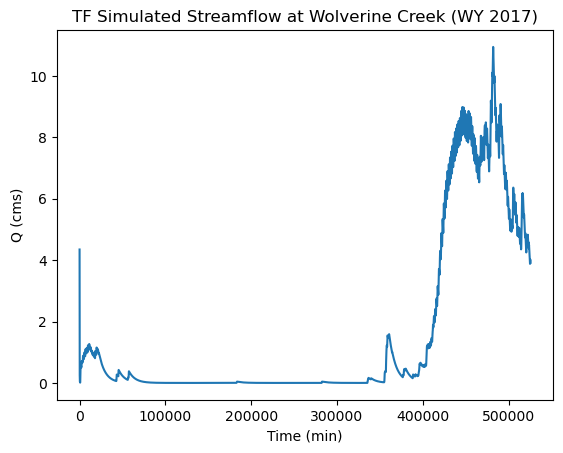

In [5]:
Q = pd.read_table('Test1_0D-Q.txt', delim_whitespace=True, skiprows=2)
Q.columns = ["Time", "A", "AU", "B", "C", "EC", "TU", "la", "n", "p", "s","t", "y", "Creek"]
plt.plot(Q.Time, Q.Creek)
plt.xlabel("Time (min)")  # add X-axis label
plt.ylabel("Q (cms)")  # add Y-axis label
plt.title("TF Simulated Streamflow at Wolverine Creek (WY 2017)")  # add title
plt.show()

### **Ice Thickness:**

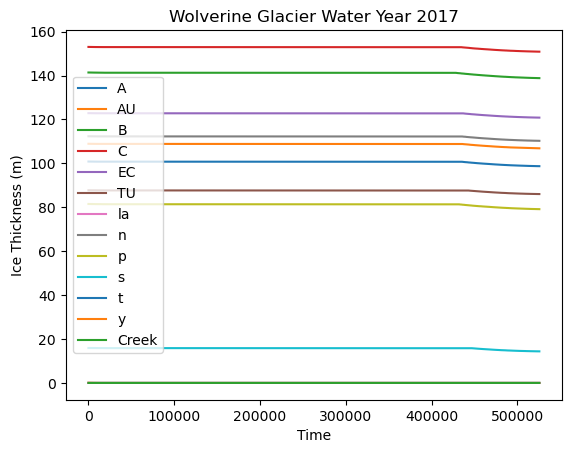

In [6]:
hice = pd.read_table('Test1_0D-hice.txt', delim_whitespace=True, skiprows=2)
hice.columns = ["Time", "A", "AU", "B", "C", "EC", "TU", "la", "n", "p", "s","t", "y", "Creek"]

# Iterate through each column except the first one (X)
for column in hice.columns[1:]:
    plt.plot(hice['Time'], hice[column], label=column)

plt.xlabel('Time')
plt.ylabel('Ice Thickness (m)')
plt.title('Wolverine Glacier Water Year 2017')
plt.legend()
plt.show()

### **Ice Meltrate:**

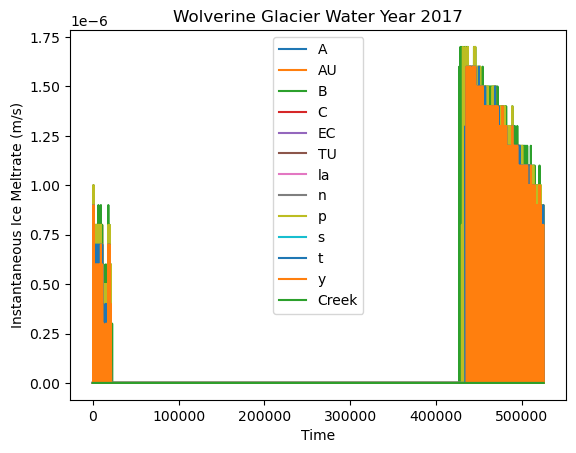

In [7]:
imrate = pd.read_table('Test1_0D-imrate.txt', delim_whitespace=True, skiprows=2)
imrate.columns = ["Time", "A", "AU", "B", "C", "EC", "TU", "la", "n", "p", "s","t", "y", "Creek"]

# Iterate through each column except the first one (X)
for column in imrate.columns[1:]:
    plt.plot(imrate['Time'], imrate[column], label=column)

plt.xlabel('Time')
plt.ylabel('Instantaneous Ice Meltrate (m/s)')
plt.title('Wolverine Glacier Water Year 2017')
plt.legend()
plt.show()

### **Snow Depth:**

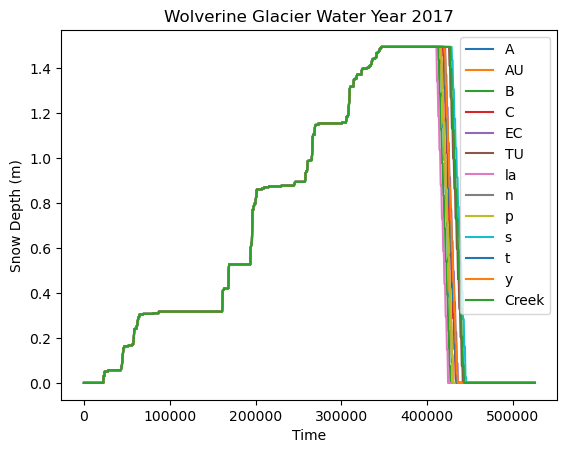

In [8]:
hsnow = pd.read_table('Test1_0D-hsnow.txt', delim_whitespace=True, skiprows=2)
hsnow.columns = ["Time", "A", "AU", "B", "C", "EC", "TU", "la", "n", "p", "s","t", "y", "Creek"]

# Iterate through each column except the first one (X)
for column in hsnow.columns[1:]:
    plt.plot(hsnow['Time'], hsnow[column], label=column)

plt.xlabel('Time')
plt.ylabel('Snow Depth (m)')
plt.title('Wolverine Glacier Water Year 2017')
plt.legend()
plt.show()

### **Snow Meltrate:**

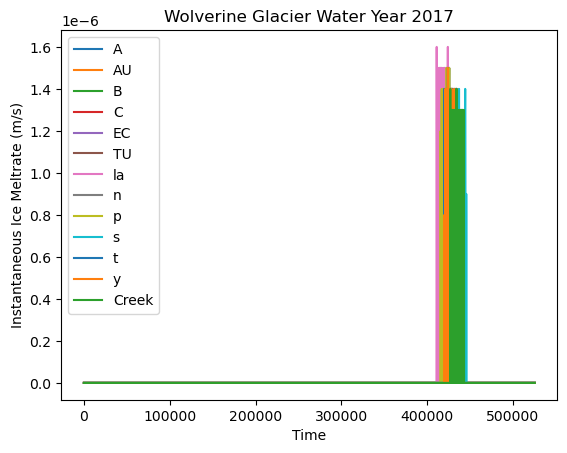

In [9]:
smrate = pd.read_table('Test1_0D-smrate.txt', delim_whitespace=True, skiprows=2)
smrate.columns = ["Time", "A", "AU", "B", "C", "EC", "TU", "la", "n", "p", "s","t", "y", "Creek"]

# Iterate through each column except the first one (X)
for column in smrate.columns[1:]:
    plt.plot(smrate['Time'], smrate[column], label=column)

plt.xlabel('Time')
plt.ylabel('Instantaneous Ice Meltrate (m/s)')
plt.title('Wolverine Glacier Water Year 2017')
plt.legend()
plt.show()